In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from obspy import UTCDateTime
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [2]:
def heat2d_fd(dx,kappa,T0):
    """
    HEAT2D_FD function to run a 2D heat equation code in 
    Python using a second order approximation

    Solve using finite difference of second order the diffusion 
    equation for a given initial boundary condition.

    matrix in 2D (nz,nx) with some initial condition. 

    """

#----------------------------------------------------------
    import numpy as np

#----------------------------------------------------------
#  Some initial checks
#----------------------------------------------------------

    
    if (nt < 2):
        print("Error, simulation too short, nt>2")
        return
    nx    = np.size(kappa,0)
    ny    = np.size(kappa,1)
    nx2   = np.size(T0,0)
    ny2   = np.size(T0,1)

    if (nx != nx2 or ny != ny2):
        print("Error, matrix sizes disagree")
        return

#----------------------------------------------------------
#  Coefficients, SECOND
#----------------------------------------------------------
    B1 = -2.0
    B2 = 1.0

#----------------------------------------------------------
# Define dx, dt, matrix sizes, etc
#----------------------------------------------------------

    rmin  = 1.0/4.0  # stability limit
    dt    = rmin*dx**2/np.amax(kappa)
    r2    = (dt/dx**2)*kappa

#    print('dt (days), dx',dt/86400,dx)
#    print(np.shape(kappa),nx,ny)

#----------------------------------------------------------
# Create T(nx,ny,nt)
#----------------------------------------------------------

    T         = np.zeros((nx,ny,2))
    T[:,:,0]  = T0

#--------------------------------------
# Run heat diffusion
#--------------------------------------

    k = 0
    T[1:-1,1:-1,k+1] = ((1 - 4*r2[1:-1,1:-1])*T[1:-1,1:-1,k]
                            + B2*r2[1:-1,1:-1]*(T[2:,1:-1,k] + T[:-2,1:-1,k]
                            +T[1:-1,2:,k]+T[1:-1,:-2,k]))


                               
    # Boundary conditions 
    T[0 , : , k+1]     = T[0 , :,0]    
    T[-1, : , k+1]     = T[-1, :,0]
    T[: , 0 , k+1]     = T[: , 0,0]   
    T[: , -1, k+1]     = T[: ,-1,0]

    return (T[:,:,1], dt)


In [3]:
#-------------------------------------------------------
# Function for M3- events
#-------------------------------------------------------
#uniform distribution
#def random_loc(mdist,zwid,xmed,xwid): #mdist = mdist*dx
#    x = np.random.randint(xmed-xwid, xmed+xwid, size=1)
#    z = np.random.randint(mdist-zwid, mdist+zwid, size=1)
#    return x,z

#Gaussian distribution
def random_loc(mdist,zwid,xmed,xwid): #mdist = mdist*dx
    x = np.random.normal(loc=xmed, scale=xwid, size=1)
    z = np.random.normal(loc=mdist, scale=zwid, size=1)
    x = np.round(x).astype(int)
    z = np.round(z).astype(int)
    return x,z

In [ ]:
#hd_reloc=['evid','latR','lonR','depR','x','y','z','ex','ey','ez','yr','mm','day','hh','mi','sec','mag','nccp','nccs','nctp','ncts','rmscc','rmsct','cid']
#catalog_all = pd.read_csv('hypoDD.reloc', header=None, delim_whitespace=True, names=hd_reloc)
#catalog_all = catalog_all[catalog_all['mag']>0]
#catalog_all = catalog_all[catalog_all['yr']>=2018]
#catalog_all.iloc[0]

In [9]:
#--------------------------------------------------------
# How to create catalog for M3- events
#--------------------------------------------------------

##HypoDD Relocated Catalog
#hd_reloc=['evid','latR','lonR','depR','x','y','z','ex','ey','ez','yr','mm','day','hh','mi','sec','mag','nccp','nccs','nctp','ncts','rmscc','rmsct','cid']
#catalog_all = pd.read_csv('hypoDD.reloc', header=None, delim_whitespace=True, names=hd_reloc)
#catalog_all = catalog_all[catalog_all['mag']>0]
#catalog_all = catalog_all[catalog_all['yr']>=2018]
#means = pd.read_csv('centroids_hypoDD.csv')

##GrowClust Relocated Catalog
catalog_all = pd.read_csv('catalog_fmf_16templates.csv', usecols=[0,2,5,34,36])
catalog_all = catalog_all[catalog_all['median Mi']>0]
catalog_all = catalog_all[catalog_all['event_time']>UTCDateTime('2018-01-01T00:00:00')]
means = pd.read_csv('centroids.csv')

zwid = 200; xwid = 100; xmed=250
r = []; rx = []; t = []; mag = []; evid = []
for i in range(len(catalog_all)):
    tempid = catalog_all['tempid'].iloc[i]
    time   = catalog_all['event_time'].iloc[i]
    mg     = catalog_all['median Mi'].iloc[i]
    eventid = catalog_all['Event No'].iloc[i]
    if tempid == 'SGC2018yyczk_39307': #This template has not been relocated, and all the other detections are below M3
        mdist1 = means[means['tempid']=='SGC2018yyczk_34942']['mdist'].iloc[0]
        mdist2 = means[means['tempid']=='SGC2018yyczk_45482']['mdist'].iloc[0]
        mdist = (mdist1+mdist2)/2
    else:
        mdist  = means[means['tempid']==tempid]['mdist'].iloc[0]
    mdist = mdist*10**3 #[m]
    x,z    = random_loc(mdist,zwid,xmed,xwid)
    while not ((0 < x < 500) and (0 < z < 2000)): #avoiding out-of-frame data
         x,z    = random_loc(mdist,zwid,xmed,xwid)
    x = x/1000
    z = z/1000
    r.extend(z)
    rx.extend(x)
    t.extend([time])
    mag.append(mg)
    evid.append(eventid)
r = np.array(r)
rx = np.array(rx)
mag = np.array(mag)
print(len(catalog_all),len(r),i)

small_events = pd.DataFrame()
small_events['time']=t
small_events['x']=rx
small_events['z']=r
small_events['mag']=mag
small_events['evid']=evid

#catalog = small_events
#catalog

#--------------------------------------------------------
# Catalog for M3+ events and conbine those two
# small catalog is completely random locations. large events are relocated, but if the locations are out of the frame, the location is choosen by random
#--------------------------------------------------------
large_events = pd.read_csv('hypo_distance_fig3.csv')
catalog = pd.concat([large_events, small_events], ignore_index=True).sort_values(by='time')

df_tempid = pd.read_csv('catalog_fmf_16templates.csv', usecols=[2,5])
tempid_list = [df_tempid[df_tempid['Event No']==evid]['tempid'].iloc[0] for evid in catalog['evid']]
catalog['tempid']=tempid_list

duplicates = catalog[catalog.duplicated('evid', keep=False)]
for evid_value in duplicates['evid'].unique():
    subset = catalog[catalog['evid'] == evid_value].sort_index() 

#    if subset.iloc[0]['x'] < 0.5:
#        catalog = catalog.drop(subset.index[1])  
#    else:
#        catalog = catalog.drop(subset.index[0]) 
        
    catalog = catalog.drop(subset.index[1])  

catalog.sort_values('evid',inplace=True)
catalog.reset_index(drop=True,inplace=True)
catalog

22823 22823 22822


,time,x,z,mag,evid,tempid
0,2018-01-01T02:32:01.640000Z,0.319000,0.582000,2.201106,6721,SGC2018yyczk_69884
1,2018-01-01T04:31:59.190000Z,0.304000,0.300000,1.665561,6722,SGC2018yyczk_34942
2,2018-01-01 04:53:17,0.587504,1.048419,3.200000,6724,SGC2018yyczk_55024
3,2018-01-01T05:15:24.810000Z,0.125000,0.712000,1.535797,6727,SGC2018yyczk_55024
4,2018-01-01T05:45:16.340000Z,0.139000,0.521000,1.414805,6728,SGC2018yyczk_34942
...,...,...,...,...,...,...
22818,2021-05-09T03:13:19.470000Z,0.305000,1.228000,2.390202,33740,SGC2018yyczk_55024
22819,2021-05-09T05:56:56.810000Z,0.121000,1.023000,1.762736,33741,SGC2018yyczk_55024
22820,2021-05-09T06:18:23.520000Z,0.342000,1.090000,2.746564,33742,SGC2018yyczk_47863
22821,2021-05-09 12:20:55,0.270182,1.178964,3.170000,33743,SGC2018yyczk_53066


## Here is the actual catalog that we use for Fig. 4

In [1]:
catalog=pd.read_csv('catalog_used_250627.csv')

NameError: name 'pd' is not defined

99.82473820269027% of events are in the frame


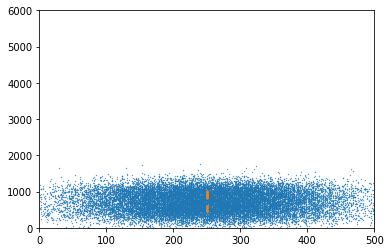

In [18]:
#-------------------------------------------
# Checking how many events are in the frame
#-------------------------------------------
plt.scatter(catalog['x']*1000,catalog['z']*1000,s=0.1)
plt.scatter([xmed]*len(means),means['mdist']*1000,s=2)
n_events_out=sum((0 < x < 500) for x in catalog['x']*1000)

print('{}% of events are in the frame'.format(100*(n_events_out/len(catalog))))
plt.xlim([0,500]);plt.ylim([0,6000])
plt.show()

In [5]:
import pandas as pd
import numpy as np

myu = 6.62*10**10       # shear modulus [Pa] from Prieto et al. (2013)
stress_drop = 10*10**6  # stress drop [10 MPa]
G_slope = 10**8         #slope of intermediate-depth earthquakes in Figure 3 (Prieto et al., 2013)

#--------------------------------------------------------
#pre-processing
#catalog = pd.read_csv('catalog_fmf_16templates.csv', usecols=[0,34,36])
#catalog = catalog[catalog['median Mi']>0]
#moment  = 10.**(1.5*catalog['median Mi']+9.1) # seismic moment [Nm]

#moment  = 10.**(1.5*catalog['mag']+9.1) # seismic moment [Nm]
moment_mag = 0.958*catalog['mag']+0.1 #SGC mag to moment mag
moment = 10.**(1.5*moment_mag+9.1) #Hanks and Kanamori (1979)

radius  = np.cbrt((7.*moment)/(16.*stress_drop))
area    = np.pi*(radius**2.) # fault area: A = r^2 * pi [m^2]
slip    = stress_drop*(16.*radius)/(7.*myu*np.pi) # slip [m]
#--------------------------------------------------------

sigma_f = 10.*10**6        # assumed frictional stress for all earthquakes [10 MPa]
C       = 1                # heat capacity from Prieto et al., 2013 [J/(g*degree of C)]
density = 3360*10**3       # [g/m^3]
swid    = [0.1,0.003,0.001] # fault width [m]
G       = G_slope*slip**2  # earthquake fracture energy per unit area

S_T_array     = np.zeros((len(swid),len(G)))
for i,width in enumerate(swid):
    S_T_array[i,]  =  G/(C*density*width) # source T increase

In [ ]:
plt.scatter(slip, G, label='Fault width:{} cm'.format(swid*10**2))
plt.xlabel('Slip [m]'); plt.ylabel('Fracture Energy G [J/m^2]')
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [ ]:
for i in range(S_T_array.shape[0]):
    plt.scatter(slip, S_T_array[i,], label='Fault width:{} cm'.format(swid[i]*10**2))
plt.xlabel('slip [m]')
plt.ylabel('Temperature increase [°C]')
plt.legend()

In [ ]:
for i in range(S_T_array.shape[0]):
    #plt.scatter(catalog['median Mi'], S_T_array[i,], label='Fault width:{} cm'.format(swid[i]*10**2))
    plt.scatter(catalog['mag'], S_T_array[i,], label='Fault width:{} cm'.format(swid[i]*10**2))
plt.xlim([0,6])
plt.yscale('log')
plt.xlabel('Magnitude')
plt.ylabel('Temperature increase [°C]')
plt.legend()

## Original code

In [ ]:
"""
Program to run a 2D heat diffusion code in 
Python using a second order approximation

Solve using finite difference of second order diffusion
equation for a given initial boundary condition.

Set up T in 2D, with some initial 
condition
Solve for next time step

Loop through time and string

"""

#----------------------------------------------------------

import numpy as np
from math import pi
# plots
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as cm
import matplotlib.pyplot as plt
import matplotlib.mlab as ml
import matplotlib.animation as animation

import pandas as pd
#--------------------------------------------------------

# Size of matrices, create matrices
nz = 6000     #nz_0 = 2000 (200 m)
nx = 1000      #nx_0 = 3000 (300 m)
nt = 10000    

# Sampling in m
dx    = 0.1     # m

# Source info + Add heat from EQ
Tsrc      = np.zeros((nz,nx))
zmed      = int(nz/2)
xmed      = int(nx/2)
swid      = 1500     # half width of fault (in samples: 100 = 10 m) 
Tsrc[zmed-swid:zmed+swid,int(nx/2)] = 1.0
S_T       = 100   # source T increase
dsrc      = 30    # dt for a repeat source

# Diffusivity model (cte diffusion)
kappa = np.ones((nz,nx))*1e-6
#kappa[:,150:] = kappa[:,150:]*10

#-------------------------------------
# Initial condition
#--------------------------------------

Ttop = 550    #Ttop0 = 300
Tbot = 500    #Tbot0 = 600
Tline = np.linspace(Ttop,Tbot,nz)
mat   = np.tile(Tline, (nx,1))  # Repeats the vector 4 times vertically
T0    = mat.T 
print(np.shape(T0))
T1 = np.copy(T0)

plt.figure(1)
im = plt.imshow(T0)
plt.colorbar(im)

#-------------------------------------
# Run heat diffusion
#--------------------------------------

nt    = 5000
nskip = int(np.round(nt/20))
print('nskip ', nskip)
t     = np.arange(nt)
print("heat routine")
for i in range(5000):#(nt):

    if (i==1):
        print('Initial parameters')
        print('dt %6.2f  min' %(dt/60))
        print('Repeat sources every %6.2f  min' %(dsrc*dt/60))
        print('T increase for source %5.1fºC' %(S_T))
    
    # Add heat source
    if (i%dsrc==0):
        T0 = T0+Tsrc*S_T   #src is S_T degrees
    
    T1,dt   = heat2d_fd(dx,kappa,T0)
    T0[:,:] = T1[:,:]
    t[i] = t[i]*dt
    if (i%nskip==0):
        plt.figure()
        im = plt.imshow(T1,vmin=Tbot,vmax=1000)
        print('Time %10.2f days' %(t[i]/86400))
        plt.figure(100)
        plt.plot(T1[zmed,:],'k')
        plt.colorbar(im)
        
print("end heat routine")

## Using relocated-catalog locations

(2000, 500)
Initial parameters
dt 4166.67  min
nskip  21
heat routine


<ipython-input-6-1d0c6e7f8402>:97: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('coolwarm')


Time      83.91 days


<ipython-input-6-1d0c6e7f8402>:221: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('coolwarm', len(temp_list))
<ipython-input-6-1d0c6e7f8402>:224: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=range(len(temp_list)))


Time     185.19 days
Time     332.75 days
Time     353.01 days
Time     387.73 days
Time     460.07 days
Time     520.83 days
Time     587.38 days
Time     645.25 days
Time     665.51 days
Time     792.82 days
Time     824.65 days
Time    1024.31 days
Time    1035.88 days
Time    1145.83 days


<ipython-input-6-1d0c6e7f8402>:182: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(5,5))


Time    1151.62 days
end heat routine


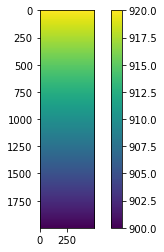

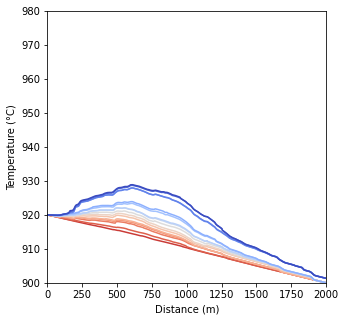

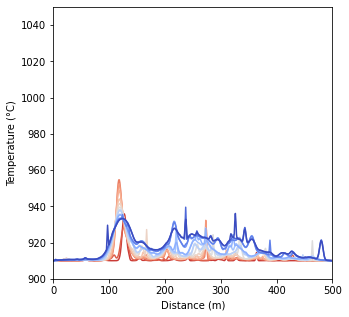

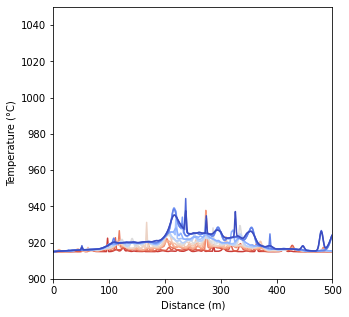

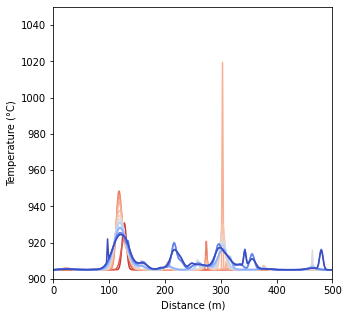

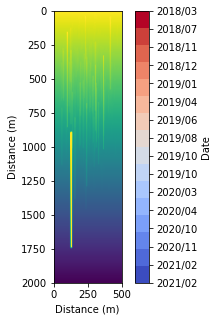

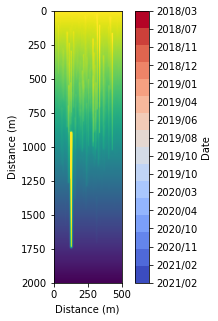

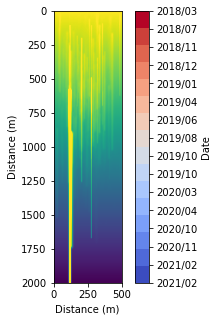

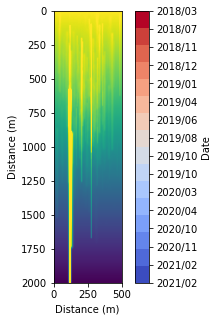

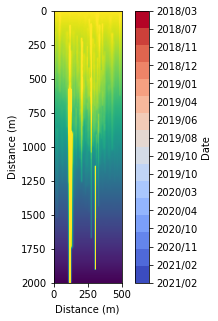

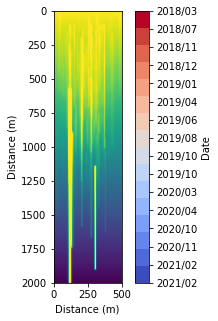

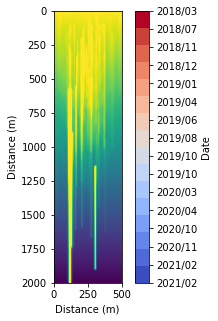

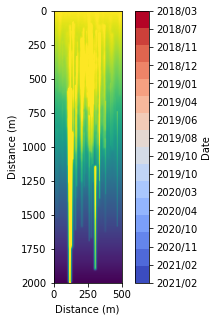

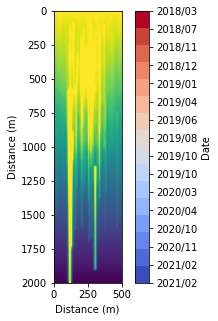

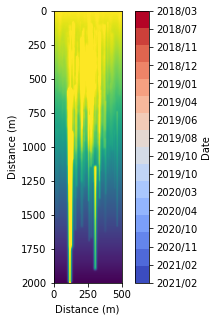

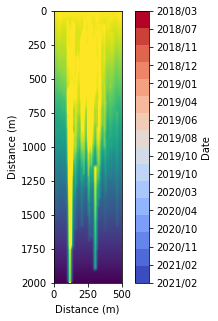

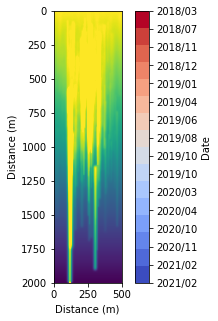

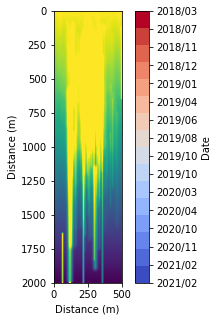

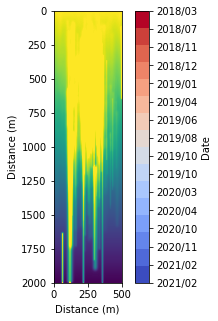

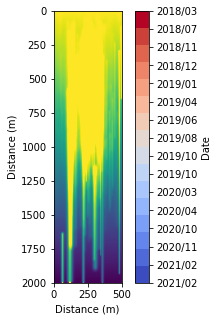

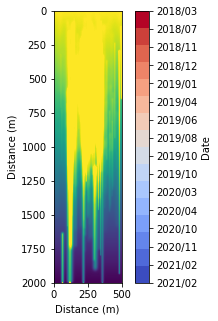

In [6]:
"""
using time series from the catalog

"""

#----------------------------------------------------------

import numpy as np
from math import pi
# plots
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as cm
import matplotlib.pyplot as plt
import matplotlib.mlab as ml
import matplotlib.animation as animation
from obspy import UTCDateTime
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

import pandas as pd
#--------------------------------------------------------

# Size of matrices, create matrices
nz = 2000    
nx = 500   

# Sampling in m
dx    = 1     # m

# Source info + Add heat from EQ
Tsrc      = np.zeros((nz,nx))
zmed      = int(nz/2)
xmed      = int(nx/2)
#swid      = 150     # half width of fault  
#Tsrc[zmed-swid:zmed+swid,int(nx/2)] = 1.0
#S_T       = 1   # source T increase
#dsrc      = 30    # dt for a repeat source

# Diffusivity model (cte diffusion)
kappa = np.ones((nz,nx))*1e-6
#kappa[:,150:] = kappa[:,150:]*10

#-------------------------------------
# Initial condition
#--------------------------------------

Ttop = 920    #Ttop0 = 300
Tbot = 900    #Tbot0 = 600
Tline = np.linspace(Ttop,Tbot,nz)
mat   = np.tile(Tline, (nx,1))  # Repeats the vector 4 times vertically
T0    = mat.T 
print(np.shape(T0))
T1 = np.copy(T0)

plt.figure(1)
im = plt.imshow(T0)
plt.colorbar(im)

#-------------------------------------------
# Convert time series into model time steps
#-------------------------------------------

time0 = UTCDateTime("2018-01-01T00:00:00")
nt = UTCDateTime(np.max(catalog['time'])) - time0
nt = nt/60 #total time length in days

Ttest,dt   = heat2d_fd(dx,kappa,T0)

nt = int(nt/(dt/60))+1
dsrc = [int(((UTCDateTime(time) - time0)/60)/(dt/60)) for time in catalog['time']]
dsrc_time = [time0 + segment_index * dt for segment_index in dsrc]
dsrc = np.array(dsrc)
radius = np.array(radius)

dsrc_time_dt = [dt.datetime for dt in dsrc_time] 
dsrc_time_dt = np.array(dsrc_time_dt)

r = np.array(catalog['z']) #km
r = dx*r*10**3
rx = np.array(catalog['x']) #km
rx = dx*rx*10**3
    
print('Initial parameters')
print('dt %6.2f  min' %(dt/60))
#print('T increase for source %5.1fºC' %(S_T))

#------------------------------------
# Making color map
#------------------------------------
import matplotlib.cm as cm
import datetime
import matplotlib.dates as mdates

temp_list = pd.read_csv('catalog_16subtemplates.csv')
cm = plt.cm.get_cmap('coolwarm')
cmap = []
for idx in range(len(temp_list)-1,-1,-1):
    cmap.append(cm(idx/len(temp_list))) #reversed coolwarm

#-------------------------------------
# Template Index
#-------------------------------------

template_index = []
for i in range(len(temp_list)):
    time = UTCDateTime(temp_list['event_time'].iloc[i])
    template_index.append(int((time - time0) / dt))

#-------------------------------------
# Run heat diffusion
#--------------------------------------

fig1=plt.figure(100, figsize=(5,5))
ax1 = fig1.add_subplot(111)
fig2=plt.figure(200, figsize=(5,5))
ax2 = fig2.add_subplot(111)
fig3=plt.figure(300, figsize=(5,5))
ax3 = fig3.add_subplot(111)
fig4=plt.figure(400, figsize=(5,5))
ax4 = fig4.add_subplot(111)
#fig5=plt.figure(500, figsize=(5,5))
#ax5 = fig5.add_subplot(111)
#fig6=plt.figure(600, figsize=(5,5))
#ax6 = fig6.add_subplot(111)
    
'''    
#norm = mcolors.Normalize(vmin=0, vmax=nt)  # iの範囲を指定
#cmap = cm.get_cmap('coolwarm_r')
cmap = mcolors.LinearSegmentedColormap.from_list("magenta_cyan", ["magenta", "cyan"])
norm = plt.Normalize(vmin=0, vmax=nt)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
'''

#fig2.colorbar(sm, ax=ax2, ticks=range(0, nt+1, 100), label='Elapsed Time (2.89 day)')
T_zmed = np.zeros((nt,T1.shape[1])); T_zmed_200 = np.zeros((nt,T1.shape[1]))
k = 0
ii = 0 

#nt    = 5000
nskip = int(np.round(nt/20))
print('nskip ', nskip)
t     = np.arange(nt)
print("heat routine")
for i in range(nt):
    # Add heat source
    #if (i%dsrc==0):
    stop_figure = []
    if i in dsrc:
        count = np.sum(dsrc == i) #count the number of events on the i-th day
        count_prev = np.sum(dsrc < i) #count the number of events until the i-th day
        for j in range(count):
            n_event_id = count_prev + j
            S_T = S_T_array[1,n_event_id] #source temperature
            #if catalog['mag'].iloc[n_event_id] > 4.5:
            #    print(S_T, catalog['mag'].iloc[n_event_id])
            if S_T > 80.:
                stop_figure.append(1)
            else:
                stop_figure.append(0)
            #swid = 150
            swid = int(radius[n_event_id])            # half width of fault (in samples)
            r_j = int(r[n_event_id])
            #rx_j = int(nx/2)
            rx_j = int(rx[n_event_id])
            if abs(rx_j) < nx: #ignore events out of frame
               #Tsrc[zmed-swid:zmed+swid,int(nx/2)] = 1.0
               #Tsrc[r_j-swid:r_j+swid,int(nx/2)] = 1.0
                Tsrc      = np.zeros((nz,nx)) #initializing, otherwise the source information would be pilled up!
                Tsrc[r_j-swid:r_j+swid,rx_j] = 1.0
                T0 = T0+Tsrc*S_T   #src is S_T deghttps://docs.google.com/spreadsheets/d/1kiJFVE1W4qdItcxHnCPSrdPzRVBdtgdbBrCKn-NyIuI/edit?usp=sharingrees
    
    T1,dt   = heat2d_fd(dx,kappa,T0)
    T0[:,:] = T1[:,:]
    t[i] = t[i]*dt
    T_zmed_200[i,] = np.mean(T1[zmed-200:zmed+200,:], axis=0) #average
    T_zmed[i,] = T1[zmed,:]
    
    #if (i%nskip==0):
    if i in template_index:
        fig = plt.figure(figsize=(5,5))
        im = plt.imshow(T1,vmin=Tbot,vmax=Ttop)
        plt.xlim([0,nx]); plt.ylim([0,nz])
        plt.xlabel('Distance (m)')
        plt.ylabel('Distance (m)')
        plt.gca().invert_yaxis()
        print('Time %10.2f days' %(t[i]/86400))
        #color = cmap(norm(i))
 
        #ax1.plot(T1[zmed,:], color=color)
        T1_zmean=np.mean(T1[:,xmed-50:xmed+50], axis=1)
        ax1.plot(T1_zmean, color=cmap[ii])
        #plt.colorbar(im)
        ax1.set_xlabel('Distance (m)')
        ax1.set_ylabel('Temperature (°C)')
        ax1.set_xlim([0,nz])
        ax1.set_ylim([Tbot,Tbot+80])
        
        ax2.plot(T1[zmed, :], color=cmap[ii])
        ax2.set_xlabel('Distance (m)')
        ax2.set_ylabel('Temperature (°C)')
        ax2.set_xlim([0,nx])
        ax2.set_ylim([Tbot,Tbot+150])
        #plt.colorbar(im)

        ax3.plot(T1[500, :], color=cmap[ii])
        ax3.set_xlabel('Distance (m)')
        ax3.set_ylabel('Temperature (°C)')
        ax3.set_xlim([0,nx])
        ax3.set_ylim([Tbot,Tbot+150])
        
        ax4.plot(T1[1500, :], color=cmap[ii])
        ax4.set_xlabel('Distance (m)')
        ax4.set_ylabel('Temperature (°C)')
        ax4.set_xlim([0,nx])
        ax4.set_ylim([Tbot,Tbot+150])
        ii = ii + 1
        
        norm = Normalize(vmin=0, vmax=15)
        cm = plt.cm.get_cmap('coolwarm', len(temp_list))
        sm = ScalarMappable(norm=norm, cmap=cm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ticks=range(len(temp_list)))
        labels=[UTCDateTime(t).strftime("%Y/%m") for t in temp_list['event_time']][::-1]
        cbar.set_ticklabels(labels)
        cbar.set_label("Date")
        
'''  
    if 1 in stop_figure:
        print('T>80 was detected')
        fig = plt.figure(figsize=(5,5))
        im = plt.imshow(T1,vmin=Tbot,vmax=Ttop)
        plt.xlim([0,nx]); plt.ylim([0,nz])
        plt.xlabel('Distance (m)')
        plt.ylabel('Distance (m)')
        plt.gca().invert_yaxis()
        color = cmap(norm(i))
        
        T1_zmean=np.max(T1[zmed-1000:zmed+1000,:], axis=0)
        ax5.plot(T1_zmean, color=color)
        plt.colorbar(im)
        ax5.set_xlabel('Distance (m)')
        ax5.set_ylabel('Temperature (°C)')
        ax5.set_xlim([0,nx])
        ax5.set_ylim([Tbot,Ttop+200])
        
        T1_zmean=np.max(T1[:,xmed-50:xmed+50], axis=1)
        ax6.plot(T1_zmean, color=color)
        plt.colorbar(im)
        ax6.set_xlabel('Distance (m)')
        ax6.set_ylabel('Temperature (°C)')
        ax6.set_xlim([0,nz])
        ax6.set_ylim([Tbot,Ttop+200])
'''
        
print("end heat routine")

In [ ]:
max_mag_idx = np.argmax(catalog['mag'])
target_time = UTCDateTime(catalog['time'].iloc[max_mag_idx])
segment_index = []
for n_days in range(3):
    tt = target_time + n_days*30*86400
    segment_index.append(int((tt - time0) / dt))
print(segment_index)
    

In [ ]:
template_index = []
for i in range(len(temp_list)):
    time = UTCDateTime(temp_list['event_time'].iloc[i])
    template_index.append(int((time - time0) / dt))
print(template_index)

In [ ]:
for i in segment_index:
    plt.plot(T_zmed[i, :], color=color)
plt.ylabel('Temperature (°C)')
plt.xlabel('Distance (m)')

In [ ]:
for i in segment_index:
    plt.plot(T_zmed_200[i, :])
plt.ylabel('Temperature (°C)')
plt.xlabel('Distance (m)')

In [ ]:
plt.hist(catalog['mag'])
plt.yscale('log')
print(len(catalog))

In [34]:
fig.savefig("xy_temperature_3mm.pdf", format="pdf", bbox_inches="tight")
fig1.savefig("y_temperature_3mm.pdf", format="pdf", bbox_inches="tight")
#fig2.savefig("x_temperature_xmed_3mm.pdf", format="pdf", bbox_inches="tight")
#fig3.savefig("x_temperature_500_3mm.pdf", format="pdf", bbox_inches="tight")
#fig4.savefig("x_temperature_1500_3mm.pdf", format="pdf", bbox_inches="tight")

In [ ]:
dsrc = [int(((UTCDateTime(time) - time0)/60)/(dt/60)) for time in catalog['time']]
dsrc_time = [time0 + segment_index * dt for segment_index in dsrc]

In [ ]:
plt.scatter(catalog['mag'],S_T_array[1,:])
plt.yscale('log')
plt.xlabel('Magnitude')
plt.ylabel('Temperature (°C)')
plt.ylim([0.01,1000])
plt.savefig("magnitude_temperature.pdf", format="pdf", bbox_inches="tight")

In [ ]:
#------------------------------------
# Making color map
#------------------------------------
import matplotlib.cm as cm
import datetime
import matplotlib.dates as mdates

temp_list = pd.read_csv('catalog_16subtemplates.csv')
cm = plt.cm.get_cmap('coolwarm')
cmap = []
for idx in range(len(temp_list)-1,-1,-1):
    cmap.append(cm(idx/len(temp_list)))

colors=[]
for i in range(len(catalog)):
    temp=catalog['tempid'].iloc[i]
    idx=temp_list[temp_list['tempid']==temp].index[0]
    colors.append(cmap[idx])
    
colors = np.array(colors)

reloc_idx=catalog[catalog['evid'].isin(large_events['evid'])].index
plt.scatter(dsrc_time_dt,r[:len(radius)],s=0.05,c=colors)
#plt.scatter(dsrc,r[:len(radius)],s=0.05,c=dsrc, cmap='cool_r')
#plt.scatter(dsrc,r[:len(radius)],s=1,c='lightgray')
#plt.scatter(dsrc[reloc_idx],r[reloc_idx],s=10,c=dsrc[reloc_idx], cmap='coolwarm_r', edgecolor='k', linewidth=1)
plt.scatter(dsrc_time_dt[reloc_idx],r[reloc_idx],s=10,c=colors[reloc_idx], edgecolor='k', linewidth=1)
plt.xlabel('Time (year)')
plt.ylabel('Distance (m)')
plt.xlim([datetime.datetime(2018, 1, 1, 0, 0),datetime.datetime(2021, 5, 10, 0, 0)])
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#plt.xlim([min(dsrc_time)-1,max(dsrc_time)+1])
plt.ylim([0,2000])
plt.gca().invert_yaxis()
plt.savefig("time_series_locations_3mm.pdf", format="pdf", bbox_inches="tight")

In [ ]:
#plt.scatter(rx[:len(radius)],r[:len(radius)],s=0.05,c=dsrc, cmap='cool_r')
#cbar = plt.colorbar()
#cbar.set_label("Time (2.89 days)")
#plt.scatter(rx[:len(radius)],r[:len(radius)],s=1,c='lightgray')
#plt.scatter(rx[reloc_idx],r[reloc_idx],s=10,c=dsrc[reloc_idx], cmap='coolwarm_r', edgecolor='k', linewidth=1)
plt.scatter(rx[:len(radius)],r[:len(radius)],s=0.05,c=colors[:len(radius)])
plt.scatter(rx[reloc_idx],r[reloc_idx],s=10,c=colors[reloc_idx], edgecolor='k', linewidth=1)
plt.xlim([0,500]); plt.ylim([0,nz])
plt.gca().invert_yaxis()
plt.xlabel('Distance (m)')
plt.ylabel('Distance (m)')
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig("locations_3mm.pdf", format="pdf", bbox_inches="tight")

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import numpy as np
import datetime

# 変数前提：
# dsrc_time_dt: datetime.datetime 型の配列 or list
# r: 距離データ（dsrc_time_dt と同じ長さ）
# dt = 250000

ref_time = datetime.datetime(2018, 1, 1)

# 色用に時間をセグメント番号化（数値化）
colors = np.array([(t - ref_time).total_seconds() / dt for t in dsrc_time_dt])

# カラーマップと正規化
vmax = int((datetime.datetime(2021, 5, 10) - ref_time).total_seconds() / dt)
norm = plt.Normalize(vmin=0, vmax=vmax)
cmap = mcolors.LinearSegmentedColormap.from_list("magenta_cyan", ["magenta", "cyan"])

# プロット
fig, ax = plt.subplots()
sc = ax.scatter(dsrc_time_dt, r, s=10, c=colors, cmap=cmap, norm=norm, edgecolor='k', linewidth=0.3)

# 軸設定
ax.set_xlabel("Time (year)")
ax.set_ylabel("Distance (m)")
ax.set_ylim([0, 2000])
ax.invert_yaxis()

# x軸を年表示
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# カラーバー
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label("Time")

# 年ごとのtick（250000秒単位）
years = [2018, 2019, 2020, 2021]
year_ticks = [int((datetime.datetime(y, 1, 1) - ref_time).total_seconds() / dt) for y in years]
year_ticks.append(int((datetime.datetime(2021, 5, 10) - ref_time).total_seconds() / dt))
cbar.set_ticks(year_ticks)
cbar.set_ticklabels([str(y) for y in years] + ['2021/5/10'])

plt.savefig("colorbar_time.pdf", format="pdf", bbox_inches="tight")


## Synthesized locations

In [ ]:
"""
using time series from the catalog

"""

#----------------------------------------------------------

import numpy as np
from math import pi
# plots
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as cm
import matplotlib.pyplot as plt
import matplotlib.mlab as ml
import matplotlib.animation as animation
from obspy import UTCDateTime

import pandas as pd
#--------------------------------------------------------

# Size of matrices, create matrices
nz = 5000    
nx = 500   

# Sampling in m
dx    = 1     # m

# Source info + Add heat from EQ
Tsrc      = np.zeros((nz,nx))
zmed      = int(nz/2)
xmed      = int(nx/2)
#swid      = 150     # half width of fault  
#Tsrc[zmed-swid:zmed+swid,int(nx/2)] = 1.0
#S_T       = 1   # source T increase
#dsrc      = 30    # dt for a repeat source

# Diffusivity model (cte diffusion)
kappa = np.ones((nz,nx))*1e-6
#kappa[:,150:] = kappa[:,150:]*10

#-------------------------------------
# Initial condition
#--------------------------------------

Ttop = 550    #Ttop0 = 300
Tbot = 500    #Tbot0 = 600
Tline = np.linspace(Ttop,Tbot,nz)
mat   = np.tile(Tline, (nx,1))  # Repeats the vector 4 times vertically
T0    = mat.T 
print(np.shape(T0))
T1 = np.copy(T0)

plt.figure(1)
im = plt.imshow(T0)
plt.colorbar(im)

#-------------------------------------------
# Convert time series into model time steps
#-------------------------------------------

time0 = UTCDateTime("2016-01-01T00:00:00")
nt = UTCDateTime(np.max(catalog['event_time'])) - time0
nt = nt/60 #total time length in days

Ttest,dt   = heat2d_fd(dx,kappa,T0)

nt = int(nt/(dt/60))+1
dsrc = [int(((UTCDateTime(time) - time0)/60)/(dt/60)) for time in catalog['event_time']]
dsrc = np.array(dsrc)
radius = np.array(radius)

kz = -200
r = []; rx = []
for k in range(0,len(radius),2000):
    kz  = kz + 50
    zlow  = int(kz - 500)
    zhigh = int(kz + 500)
    points = np.random.randint(zmed+zlow, zmed+zhigh, size=2000) #source locations
    xpoints = np.random.randint(int(nx/2)-250, int(nx/2)+250, size=2000)
    r.extend(points)
    rx.extend(xpoints)
r = np.array(r)
rx = np.array(rx)
    
print('Initial parameters')
print('dt %6.2f  min' %(dt/60))
#print('T increase for source %5.1fºC' %(S_T))

#-------------------------------------
# Run heat diffusion
#--------------------------------------

#nt    = 5000
nskip = int(np.round(nt/20))
print('nskip ', nskip)
t     = np.arange(nt)
print("heat routine")
for i in range(nt):
    
    # Add heat source
    #if (i%dsrc==0):
    if i in dsrc:
        count = np.sum(dsrc == i) #count the number of events
        count_prev = np.sum(dsrc <= i-1)
        for j in range(count):
            n_event_id = count_prev + j
            S_T = S_T_array[1,n_event_id] #source temperature
            #swid = 150
            swid = int(radius[n_event_id])            # half width of fault (in samples)
            r_j = r[n_event_id]
            #rx_j = int(nx/2)
            rx_j = rx[n_event_id]
            #Tsrc[zmed-swid:zmed+swid,int(nx/2)] = 1.0
            #Tsrc[r_j-swid:r_j+swid,int(nx/2)] = 1.0
            Tsrc      = np.zeros((nz,nx)) #initializing, otherwise the source information would be pilled up!
            Tsrc[r_j-swid:r_j+swid,rx_j] = 1.0
            T0 = T0+Tsrc*S_T   #src is S_T degrees
    
    T1,dt   = heat2d_fd(dx,kappa,T0)
    T0[:,:] = T1[:,:]
    t[i] = t[i]*dt
    if (i%nskip==0):
        plt.figure(figsize=(5,5))
        im = plt.imshow(T1,vmin=Tbot,vmax=1000)
        print('Time %10.2f days' %(t[i]/86400))
        plt.figure(100)
        plt.plot(T1[zmed,:],'k')
        plt.colorbar(im)
        
        plt.figure(200)
        plt.plot(T1[:,xmed],'k')
        #plt.colorbar(im)
        
print("end heat routine")

In [ ]:
#T0 = T0+Tsrc*S_T
#plt.imshow(Tsrc,vmin=0,vmax=1)
Tsrc[r_j-swid:r_j+swid,rx_j] = 1.0

In [ ]:
#len(r)
plt.scatter(dsrc,r[:len(radius)],s=1,c=dsrc, cmap='coolwarm_r')
plt.gca().invert_yaxis()

In [ ]:
plt.scatter(rx[:len(radius)],r[:len(radius)],s=1,c=dsrc, cmap='coolwarm_r')
plt.xlim([0,nx]); plt.ylim([0,nz])
plt.gca().invert_yaxis()

In [ ]:
plt.scatter(dsrc,radius,s=1,c='k')

In [ ]:
plt.scatter(dsrc,catalog['median Mi'])

In [ ]:
time = [UTCDateTime(time) for time in catalog['event_time']]
plt.scatter(time,catalog['median Mi'])

In [ ]:
dsrc = np.array(dsrc)
np.sum(dsrc <= 0)